# Proyecto 1 - Analítica de textos

## Etapa 1 - Construcción de modelos de analítica de textos

**Integrantes:**
- Estudiante 1: Daniela Echavarria Yepes - 202111348
- Estudiante 2: Diego Alejandro Molano Roa - 202123015
- Estudiante 3: Juan Manuel Rodriguez Diaz - 202013372


# Introducción y objetivo



## Importación de librerías

In [38]:
!pip install wordcloud nltk spacy

   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.9 MB 3.4 MB/s eta 0:00:04
   ----- ---------------------------------- 1.8/13.9 MB 5.2 MB/s eta 0:00:03
   ---------- ----------------------------- 3.7/13.9 MB 6.3 MB/s eta 0:00:02
   ----------------- ---------------------- 6.0/13.9 MB 7.6 MB/s eta 0:00:02
   -------------------------- ------------- 9.2/13.9 MB 9.2 MB/s eta 0:00:01
   -------------------------------------- - 13.4/13.9 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 13.9/13.9 MB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/630.6 kB ? eta -:--:--
   --------------------------------------- 630.6/630.6 kB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 19.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ------------------

In [39]:
# ====================================
# 1. Importación de librerías
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            r2_score,
                            confusion_matrix,
                            classification_report,
                            precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score, 
                            ConfusionMatrixDisplay)
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as stats

from sklearn import tree
#import sklearn as sklearn

import unicodedata
import re

from wordcloud import WordCloud
import nltk
import spacy

# Configuración
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


# Carga de datos

In [40]:
# ====================================
# 2. Carga de datos
# ====================================
df = pd.read_excel("Datos_proyecto.xlsx")
print(f"Filas y columnas: {df.shape}")
display(df.head())
print(df["textos"].iloc[0])  # Ejemplo de texto

Filas y columnas: (2424, 2)


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


"Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


# 1. Entendimiento inicial de los datos

## 1.1 Distribución de la longitud de filas

In [41]:
df["longitud"] = df["textos"].str.len()
df["longitud"].describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud, dtype: float64

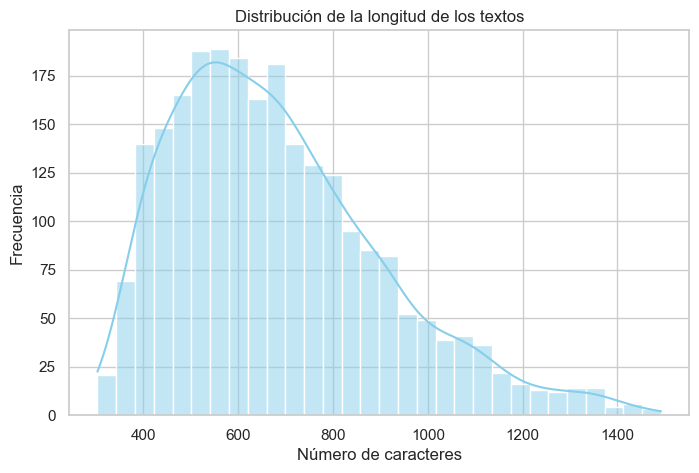

In [42]:
plt.figure(figsize=(8,5))
sns.histplot(df["longitud"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

## 1.2 Distribución de la variable objetivo

Observamos el balance de clases para el atributo "labels".

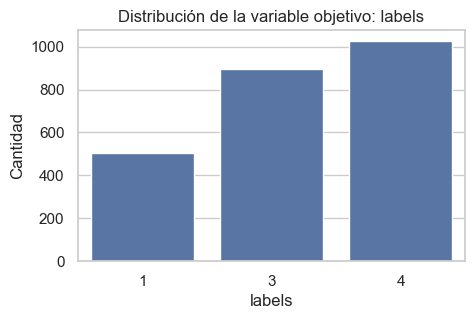

In [43]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

# 2. Limpieza y preparación de datos

In [44]:
df = df.drop_duplicates(subset="textos")
print(df.shape)

(2424, 3)


In [45]:
df = df.dropna(subset=["textos", "labels"])
print(df.shape)

(2424, 3)


## 2.1 Normalización

1. Pasar todo a minúsculas
2. Eliminar acentos
3. Eliminar caractéres especiales
4. Eliminar espacios adicionales

In [46]:
n_norm = 0

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Pasar a minúsculas
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore').decode("utf-8")  # Eliminar acentos
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip() # Eliminar espacios extra
    return text

df["textos"] = df["textos"].apply(normalize_text)

print("Ejemplo de normalizacion: " + df["textos"].iloc[0])  # Ejemplo de texto normalizado

Ejemplo de normalizacion: aprendizaje y educacion se consideran sinonimos de escolarizacion formal las organizaciones auxiliares como las editoriales de educacion las juntas examinadoras y las organizaciones de formacion de docentes se consideran extensiones de los acuerdos establecidos por los gobiernos este marco de comprension se ha vuelto cada vez mas inadecuado


## 2.2 Tokenización

In [48]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))
print(len(stop_words), "stopwords cargadas")
for i in range(int(len(stop_words)/10) + 1):
    print(list(stop_words)[i*10:(i+1)*10])
print(stop_words)

313 stopwords cargadas
['porque', 'teníamos', 'mis', 'tuviéramos', 'seríais', 'tenga', 'tenido', 'sí', 'todos', 'fui']
['estada', 'tuya', 'había', 'todo', 'he', 'tuviese', 'tengáis', 'no', 'estoy', 'y']
['o', 'serían', 'habréis', 'sería', 'hay', 'esos', 'se', 'estados', 'tenías', 'esta']
['habidos', 'vosotros', 'habríais', 'son', 'tendremos', 'teniendo', 'estés', 'fuiste', 'tienes', 'muy']
['mía', 'tengas', 'tenidos', 'has', 'fuera', 'su', 'quienes', 'mi', 'durante', 'hemos']
['estaremos', 'sentidos', 'sin', 'lo', 'estuviésemos', 'fuésemos', 'os', 'estás', 'sus', 'sea']
['teníais', 'estuvieras', 'estuviera', 'hayáis', 'esto', 'estad', 'con', 'estaría', 'estéis', 'tuviesen']
['habidas', 'como', 'estar', 'nada', 'estuviéramos', 'tengo', 'estando', 'estuve', 'tendréis', 'tuve']
['antes', 'fue', 'te', 'tuvieses', 'estarían', 'hubiesen', 'seas', 'le', 'han', 'seréis']
['hayas', 'vuestro', 'más', 'tuvieras', 'ese', 'somos', 'estarán', 'pero', 'mí', 'las']
['habéis', 'otras', 'mucho', 'hubies

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["textos_limpios"] = df["textos"].apply(remove_stopwords)

print("Ejemplo de texto limpio: " + df["textos_limpios"].iloc[0])  # Ejemplo de texto limpio

Ejemplo de texto limpio: aprendizaje educacion consideran sinonimos escolarizacion formal organizaciones auxiliares editoriales educacion juntas examinadoras organizaciones formacion docentes consideran extensiones acuerdos establecidos gobiernos marco comprension vuelto cada vez mas inadecuado


## 2.3 Lematización

Opcional.

## 2.4 Visualización palabras más repetidas

In [ ]:
from collections import Counter

all_text = " ".join(df["textos_limpios"])
tokens = all_text.split()

# Contar frecuencia de cada palabra
word_freq = Counter(tokens)

# Mostrar las 20 más comunes
for palabra, freq in word_freq.most_common(20):
    print(f"{palabra}: {freq}")


mas: 1797
salud: 1107
pobreza: 1019
educacion: 992
paises: 962
atencion: 900
tambien: 767
estudiantes: 741
ocde: 587
escuelas: 586
anos: 559
servicios: 548
nivel: 521
sistema: 508
ninos: 479
personas: 457
pueden: 453
calidad: 447
desarrollo: 439
resultados: 416


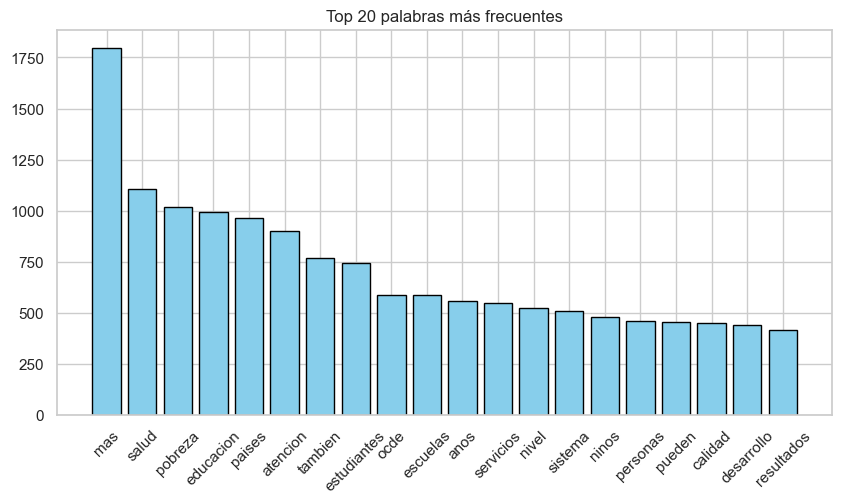

In [54]:
# Convertir a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=["Palabra", "Frecuencia"])

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(freq_df["Palabra"], freq_df["Frecuencia"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45)
plt.title("Top 20 palabras más frecuentes")
plt.show()


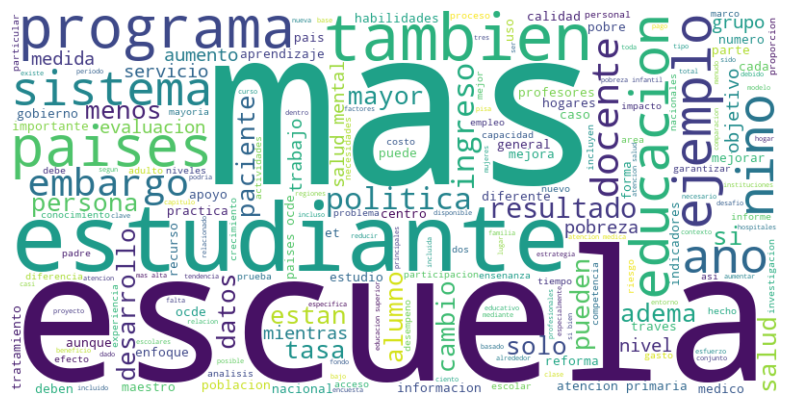

In [53]:

all_text = " ".join(df["textos_limpios"])
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


## 2.5 Vectorización

# 3. División train/test